<a href="https://www.kaggle.com/code/erfanhr/scrnaseq-analysis?scriptVersionId=114639018" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 5.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=7e9fdf2b6761b44c4c8b2679fa75756b0cc193ef5708cd0061b907a776dfc853
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info


In [2]:
# Importing the necessary libraries

import os 

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Finding the file

os.listdir("/kaggle/input/single-cell-rna-seq-from-stoeckius-et-al-2017")

['GSE100866_CD8_merged-RNA_umi.csv']

In [4]:
# reading the file

adata = sc.read_csv("../input/single-cell-rna-seq-from-stoeckius-et-al-2017/GSE100866_CD8_merged-RNA_umi.csv").T
adata

AnnData object with n_obs × n_vars = 1774 × 11757

# EDA & Data Cleaning

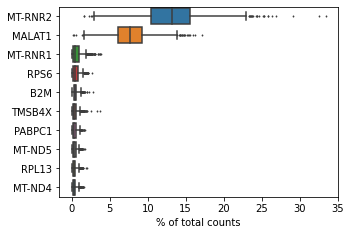

In [5]:
# Top 10 highly expressed genes

sc.pl.highest_expr_genes(adata, n_top = 10)

In [6]:
# 1 - Annotating mitochondrial genes
# 2 - Calculating qc metrics

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"],
                          percent_top = None, log1p = False,
                          inplace = True)

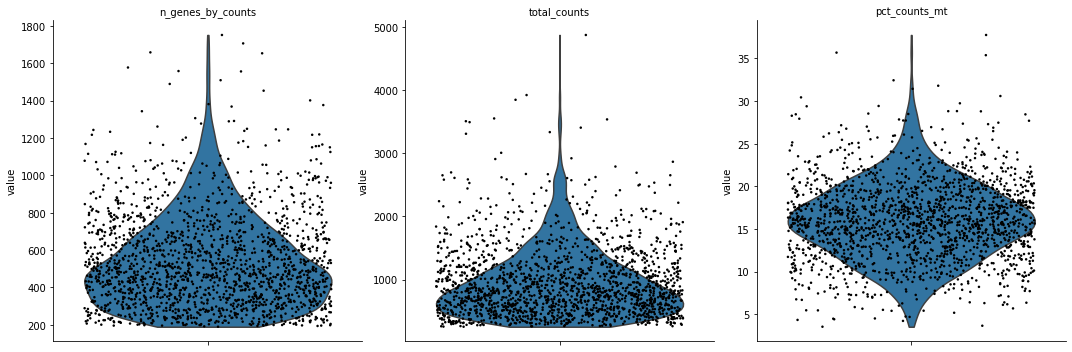

In [7]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter = 0.4, multi_panel = True, size = 2.5,
            ylabel = "Value", show = True)

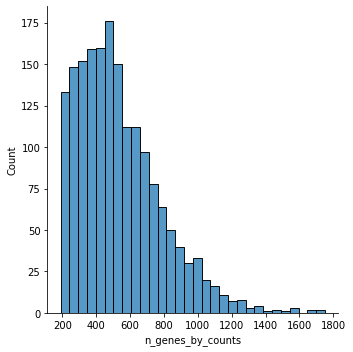

In [8]:
sns.displot(adata.obs["n_genes_by_counts"])
plt.show()

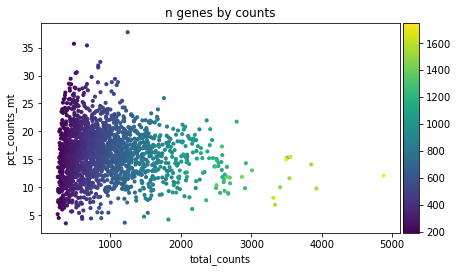

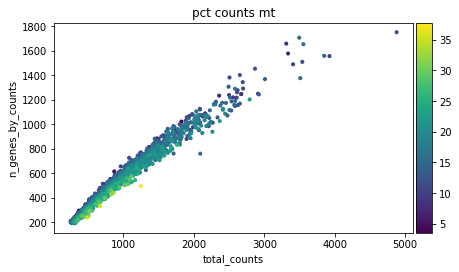

In [9]:
# Detecting outliers 

sc.pl.scatter(adata, x = "total_counts", y = "pct_counts_mt",
             color = "n_genes_by_counts")

sc.pl.scatter(adata, x = "total_counts", y = "n_genes_by_counts", 
              color = "pct_counts_mt")

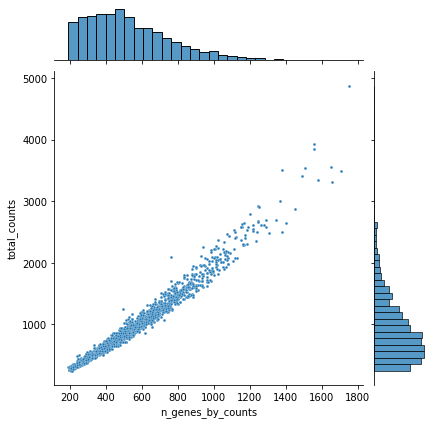

In [10]:
sns.jointplot(
    x = "n_genes_by_counts",
    y = "total_counts",
    data = adata.obs,
    kind = "scatter",
    s = 8
)
plt.show()

In [11]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

In [12]:
# Removing outliers 

bdata = adata
bdata = bdata[bdata.obs.n_genes_by_counts < 1400, :]
bdata = bdata[bdata.obs.pct_counts_mt < 30, :]

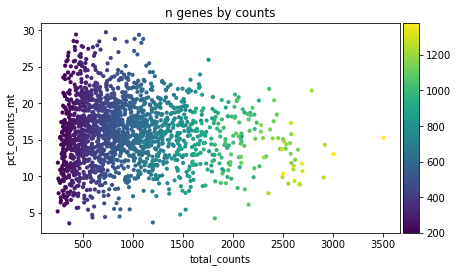

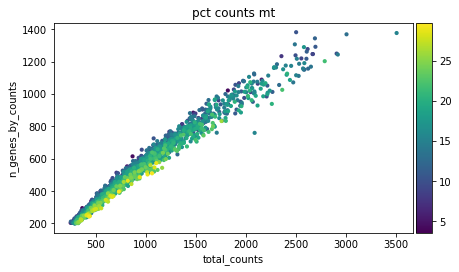

In [13]:
# Visualizinng the normal data

sc.pl.scatter(bdata, x = "total_counts", y = "pct_counts_mt",
             color = "n_genes_by_counts")

sc.pl.scatter(bdata, x = "total_counts", y = "n_genes_by_counts", 
              color = "pct_counts_mt")

# Clustering Analysis

In [14]:
!pip install kneed

In [15]:
# Importing necessary libraries

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl

#### 1 - Normalization

In [16]:
norm_data = bdata.copy()

# Normalize counts to 10000 reads per cell
sc.pp.normalize_total(norm_data, target_sum = 1e4)
sc.pp.log1p(norm_data)

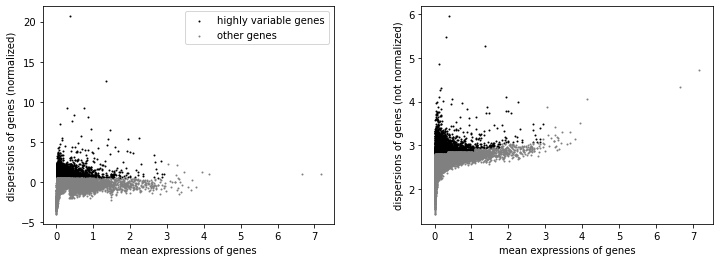

In [17]:
# Identify highly variable genes
# Parameters are arbitrary

sc.pp.highly_variable_genes(norm_data, min_mean = 0.0125,
                           max_mean = 3,
                           min_disp = 0.5)
sc.pl.highly_variable_genes(norm_data)

#### 2 - Clustering 

In [18]:
HVG_data = norm_data.copy()
HVG_data.raw = HVG_data
HVG_data = HVG_data[:, HVG_data.var.highly_variable]

In [19]:
# Scaling to unit variance for PCA

pcHVG_data = HVG_data.copy()
sc.pp.scale(pcHVG_data, max_value = 10)

In [20]:
# Fitting and saving

sc.tl.pca(pcHVG_data, svd_solver = "arpack")
pcHVG_data.write("PCAresult.pbmc3k.h5ad")

In [21]:
pcHVG_data

AnnData object with n_obs × n_vars = 1738 × 3045
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

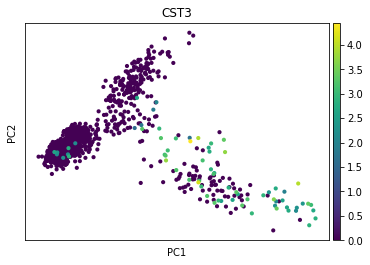

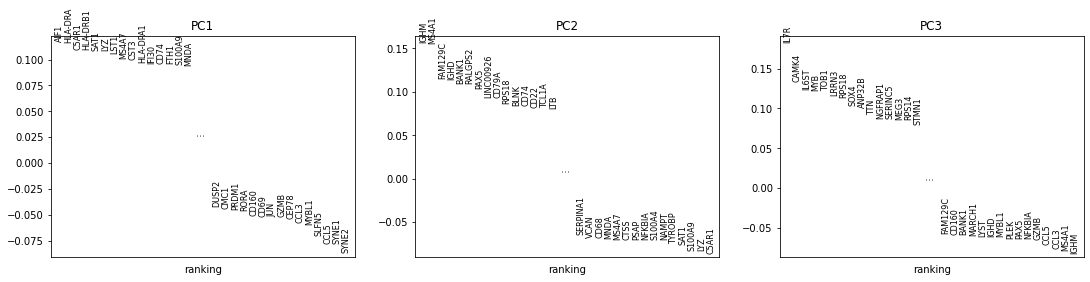

In [22]:
# Visualizing the result

sc.pl.pca(pcHVG_data, color = "CST3")
sc.pl.pca_loadings(pcHVG_data)

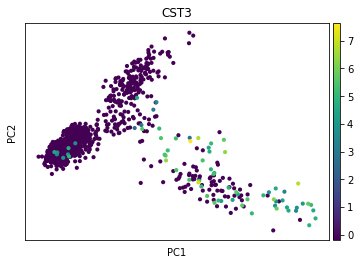

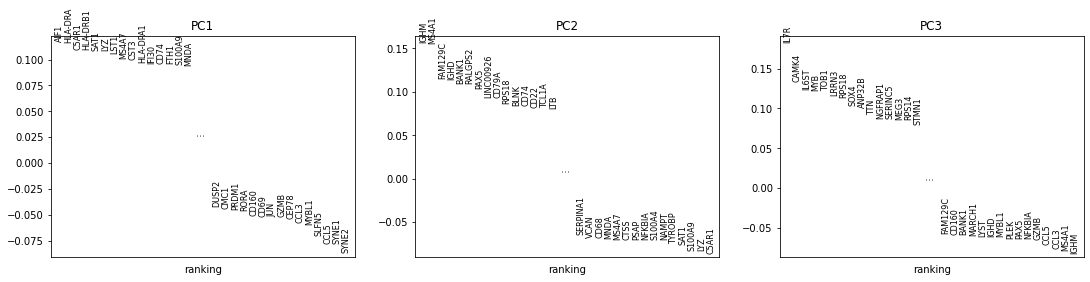

In [23]:
sc.pp.scale(norm_data, max_value = 10)
sc.tl.pca(norm_data, svd_solver = "arpack")
sc.pl.pca(norm_data, color = "CST3")
sc.pl.pca_loadings(norm_data)

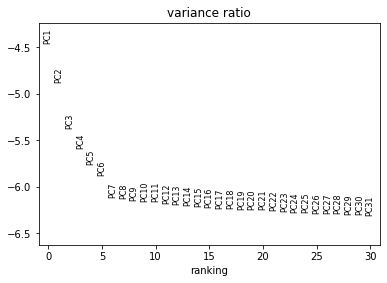

In [24]:
# Visualize the scree plot for PCA 

sc.pl.pca_variance_ratio(pcHVG_data, log = True)

In [25]:
def PCA_Elbow_fit(data):
    model = PCA().fit(data)
    explained_variance = model.explained_variance_ratio_
    pcs = list(range(1, explained_variance.shape[0] + 1))
    klm = kl(pcs, explained_variance, S = 1.0, 
             curve = "convex", direction = "decreasing")
    pcs_used = klm.knee
    pc_list = list(range(1, pcs_used + 1))
    new_data = PCA(n_components = pcs_used, svd_solver = "arpack").fit_transform(data)
    return pcs_used, new_data, pcs, explained_variance, pc_list

In [26]:
label = "HVG_data"
new_frame = pd.DataFrame(HVG_data.X.toarray(), index = HVG_data.obs_names,
                        columns = HVG_data.var_names)
pandas_data = new_frame.values

In [27]:
# Calculating the optimal number of PC by utiliizing PCA_Elbow_fit function

dim, new_matrix, pc_ax, pc_ay, col_labels = PCA_Elbow_fit(pandas_data)
print(dim)

66


In [28]:
# Saving the result

columns = ["PC_" + str(i) for i in col_labels]
output_path = "PCA_" + label + str(dim) + ".csv"
PC_frame = pd.DataFrame(new_matrix, index = new_frame.index.values.tolist(),
                       columns = columns)
print(PC_frame.head())
print(PC_frame.shape)

                           PC_1       PC_2      PC_3      PC_4      PC_5  \
CD8_off_CCTGCATATCTT   6.081266   0.936063 -0.154090  2.851763 -1.439866   
CD8_off_CCAAGATTGTGA   5.748085  -2.636666  0.686086  2.289227 -1.275109   
CD8_off_CTCCGGACAACC   6.103026  -1.809927  0.238873 -0.047217 -1.467116   
CD8_off_CCACTTCCCTCT  11.863375  11.374779  2.871877  2.297675 -0.597350   
CD8_off_ACAATCCCGTGG   6.173272  -1.544451  2.333847  4.397080 -3.206958   

                          PC_6      PC_7      PC_8      PC_9     PC_10  ...  \
CD8_off_CCTGCATATCTT  2.519438 -4.398501  0.679432 -0.342332  1.993808  ...   
CD8_off_CCAAGATTGTGA  3.793404 -2.715472  1.099720 -0.227357  1.100190  ...   
CD8_off_CTCCGGACAACC  3.062915 -0.143806  2.093877 -3.191975  2.511950  ...   
CD8_off_CCACTTCCCTCT  3.304728  3.940874 -3.239776  2.028543 -0.466543  ...   
CD8_off_ACAATCCCGTGG  6.116803 -4.085457  1.680372  2.362791  2.566249  ...   

                         PC_57     PC_58     PC_59     PC_60     PC_

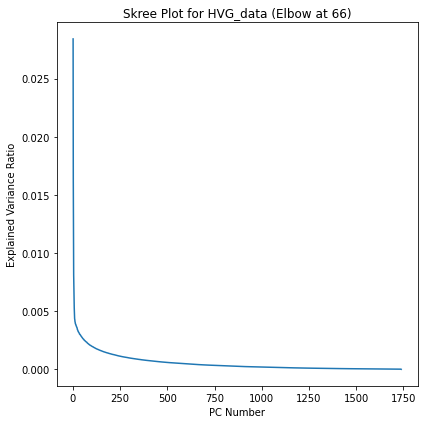

In [29]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree Plot for " + label + " (Elbow at " + str(dim) + ")")
ax1.plot(pc_ax, pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained Variance Ratio")
fig.tight_layout()

In [30]:
# Fitting KNN model

sc.pp.neighbors(pcHVG_data, n_neighbors = 10, n_pcs = sc.pp.pca(pcHVG_data, n_comps = 66))

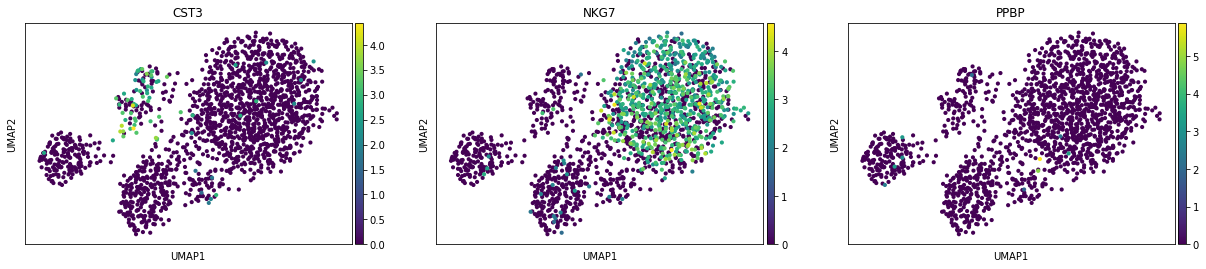

In [31]:
# Visualizing data with umap

sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color = ["CST3", "NKG7", "PPBP"])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


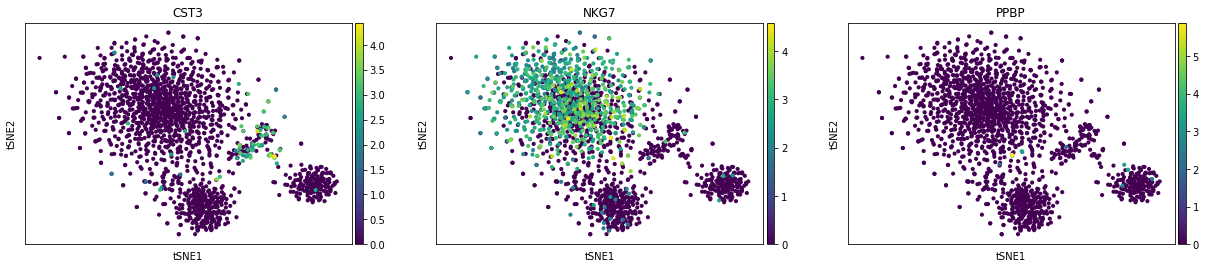

In [32]:
# Visualizing with t-SNE

sc.tl.tsne(pcHVG_data, n_pcs = dim)
sc.pl.tsne(pcHVG_data, color = ["CST3", "NKG7", "PPBP"])

In [33]:
# Clustering the neighboring graph
# Leiden clustering

!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.0 MB/s eta 0:00:00


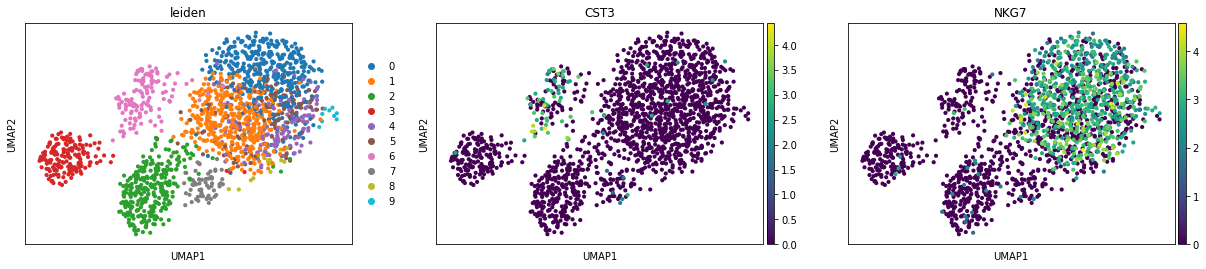

In [34]:
sc.tl.leiden(pcHVG_data, resolution = 1)
sc.pl.umap(pcHVG_data, color = ["leiden", "CST3", "NKG7"])

In [35]:
pcHVG_data.write("Leidenresult.pbmc3k.h5ad")

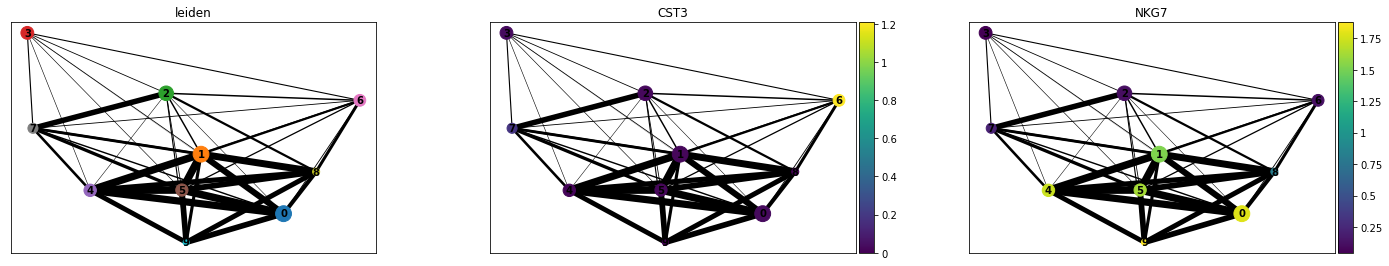

In [36]:
# Computing paga graphs

sc.tl.paga(pcHVG_data, groups = "leiden")
sc.pl.paga(pcHVG_data, color = ["leiden", "CST3", "NKG7"])

In [37]:
!pip install fa2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.4/435.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fa2: filename=fa2-0.3.5-cp37-cp37m-linux_x86_64.whl size=379855 sha256=b6de052e30751395adccd616aaf8db2265e2ef219ff51d98ec2dab21a686f558
  Stored in directory: /root/.cache/pip/wheels/d3/b5/0a/df14cac170d872be0dd0300309b7463b5e52d936c3edce7963
Successfully built fa2


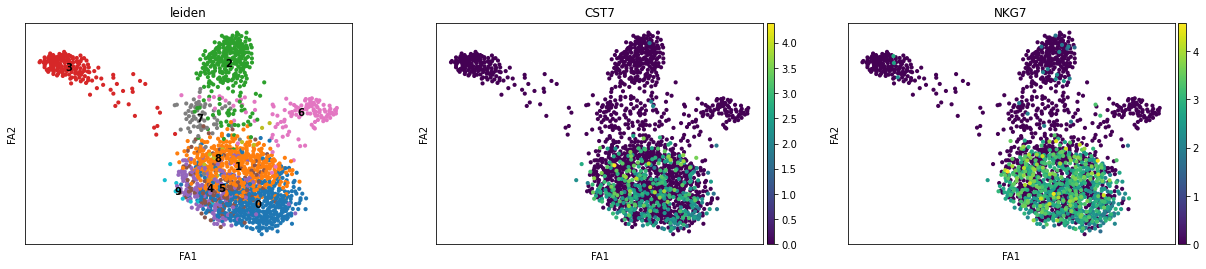

In [38]:
sc.tl.draw_graph(pcHVG_data, init_pos = "paga")
sc.pl.draw_graph(pcHVG_data, color = ["leiden", "CST7", "NKG7"],
                legend_loc = "on data")

# Evaluation

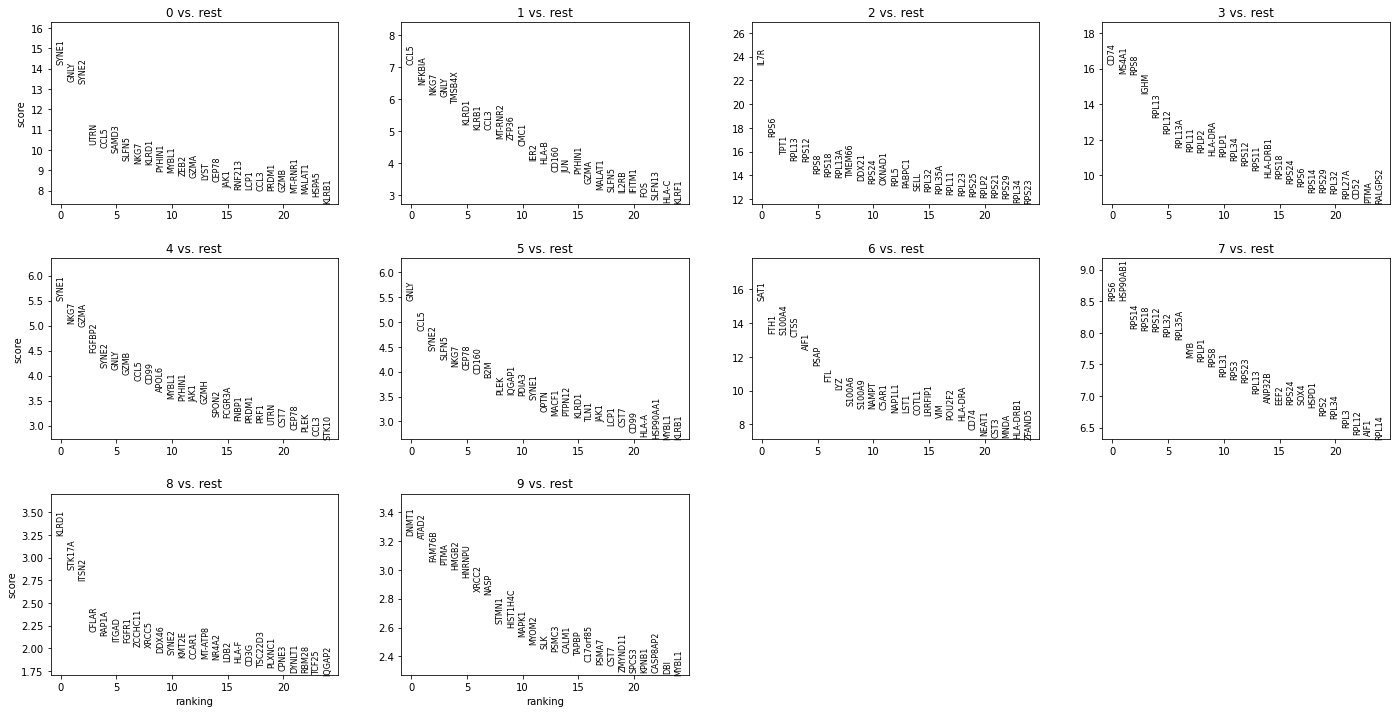

In [39]:
# Finding marker genes
# Computing rankings for differential genes in each cluster by wilcoxon rank-sum

sc.tl.rank_genes_groups(pcHVG_data, "leiden", method = "wilcoxon")
sc.pl.rank_genes_groups(pcHVG_data, n_genes = 25, sharey = False)

In [40]:
pcHVG_data.write("WilcoxonComputation.pbmc3k.h5ad")

In [41]:
# Creating references

marker_genes = ["IL7R", "CD79A", "MS4A1", "CD8A", "CD88", "LYZ",
               "CD14", "LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1",
               "FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"]

In [42]:
data = sc.read("WilcoxonComputation.pbmc3k.h5ad")
data.uns['log1p']["base"] = None
pd.DataFrame(data.uns["rank_genes_groups"]["names"]).head()

,0,1,2,3,4,5,6,7,8,9
0,SYNE1,CCL5,IL7R,CD74,SYNE1,GNLY,SAT1,RPS6,KLRD1,DNMT1
1,GNLY,NFKBIA,RPS6,MS4A1,NKG7,CCL5,FTH1,HSP90AB1,STK17A,ATAD2
2,SYNE2,NKG7,TPT1,RPS8,GZMA,SYNE2,S100A4,RPS14,ITSN2,FAM76B
3,UTRN,GNLY,RPL13,IGHM,FGFBP2,SLFN5,CTSS,RPS18,CFLAR,PTMA
4,CCL5,TMSB4X,RPS12,RPL13,SYNE2,NKG7,AIF1,RPS12,RAP1A,HMGB2


In [43]:
result = data.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame({group + "_" + key[:1]: result[key][group]
             for group in groups for key in ["names", "pvals"]}).head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p
0,SYNE1,7.075099e-46,CCL5,1.455190e-12,IL7R,1.419169e-120,CD74,2.647983e-59,SYNE1,3.460002e-08,GNLY,5.148548e-08,SAT1,2.101346e-53,RPS6,1.564954e-17,KLRD1,0.001176,DNMT1,0.001202
1,GNLY,7.376796e-41,NFKBIA,1.095867e-10,RPS6,4.166349e-67,MS4A1,6.623555e-56,NKG7,4.251457e-07,CCL5,1.351659e-06,FTH1,7.089065e-41,HSP90AB1,1.749900e-17,STK17A,0.004120,ATAD2,0.001294
2,SYNE2,2.578371e-40,NKG7,7.997534e-10,TPT1,2.680114e-56,RPS8,1.671702e-55,GZMA,6.083756e-07,SYNE2,9.096719e-06,S100A4,1.965487e-40,RPS14,7.148344e-16,ITSN2,0.005914,FAM76B,0.002202
3,UTRN,9.982350e-25,GNLY,1.147068e-09,RPL13,1.913164e-52,IGHM,3.474684e-48,FGFBP2,7.791690e-06,SLFN5,2.132438e-05,CTSS,7.104961e-40,RPS18,9.216300e-16,CFLAR,0.028817,PTMA,0.002379
4,CCL5,3.632423e-24,TMSB4X,4.968659e-09,RPS12,3.156616e-52,RPL13,4.413426e-40,SYNE2,3.074381e-05,NKG7,4.066299e-05,AIF1,1.247002e-35,RPS12,1.043410e-15,RAP1A,0.032339,HMGB2,0.002697


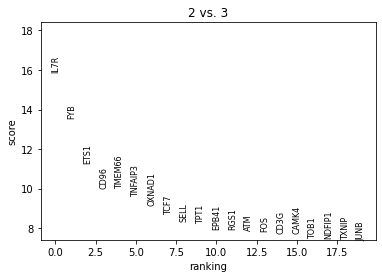

In [44]:
# Comparing to the single cluster

sc.tl.rank_genes_groups(data, "leiden", groups = ["2"], 
                        reference = "3", method = "wilcoxon")
sc.pl.rank_genes_groups(data, groups = ["2"], n_genes = 20)

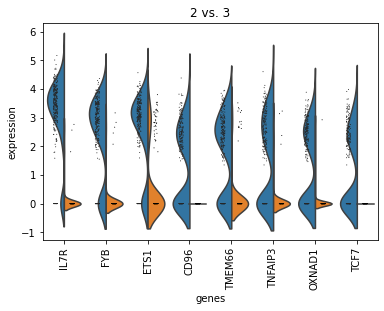

In [45]:
sc.pl.rank_genes_groups_violin(data, groups = "2", n_genes = 8)

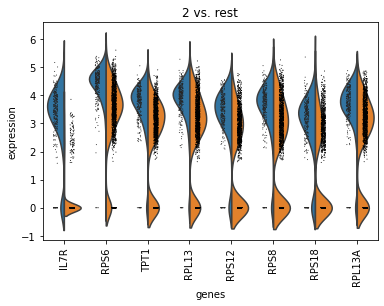

In [46]:
# Comparing cluster 0 to the others

data = sc.read("WilcoxonComputation.pbmc3k.h5ad")
data.uns['log1p']["base"] = None
sc.pl.rank_genes_groups_violin(data, groups = "2", n_genes = 8)

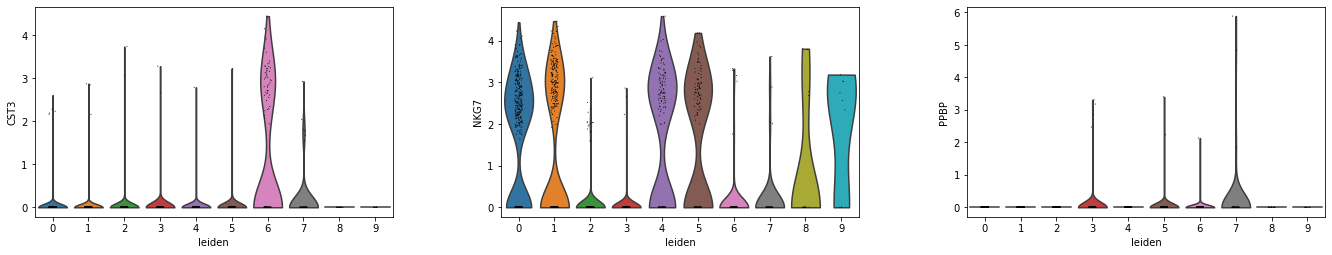

In [47]:
# Compare gene across groups 

sc.pl.violin(data, ["CST3", "NKG7", "PPBP"], groupby = "leiden")